# Introduction #

Thanks to Kaggle mini-courses on computer vision for getting me started on this.
My first trained CNN to classify the card images heavily inspired by Francesco Marazz's CNN (https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb) for the Histopathologic Cancer Detection competition (https://www.kaggle.com/c/histopathologic-cancer-detection).

My objective here is to build my first image classifier using Keras. Rare Pokemon cards are highly sought after by collectors, with some even reaching re-sale prices of hundreds of thousands of dollars. It would be important for collectors to tell a genuine card from fake card to avoid getting duped. Experienced collectors are able to tell the different between a genuine and fake card by looking at the features of the back of the card alone, but this might not be so obvious for newcomers. The image classifier described below will aim to classify, with high accuracy (>95%), Pokemon cards as genuine or fake based on the back visuals of the card alone. In future work, the model can be made more robust by including more counterfeit variations, folded, torn, new and old cards in the training, validation and test sets.

# Load Data #

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import shutil
print(os.listdir("../input"))

from glob import glob 
from skimage.io import imread
import gc

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


['real-and-fake-pokemon-cards']


In [2]:
base_tile_dir = '../input/real-and-fake-pokemon-cards/train'
df = pd.DataFrame({'path': glob(os.path.join(base_tile_dir,'*.JPG'))})
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0])
labels = pd.read_csv("../input/real-and-fake-pokemon-cards/train_labels.csv")
labels['id'] = labels['id'].astype('str')
labels = labels.sort_values(by=['id'], ignore_index = True)
df['id'] = df['id'].astype('str')
df = df.sort_values(by=['id'], ignore_index = True)
df_data = pd.merge(labels, df, on="id")


# Data Visualization #

In [3]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

Text(0, 0.5, 'Fake Cards')

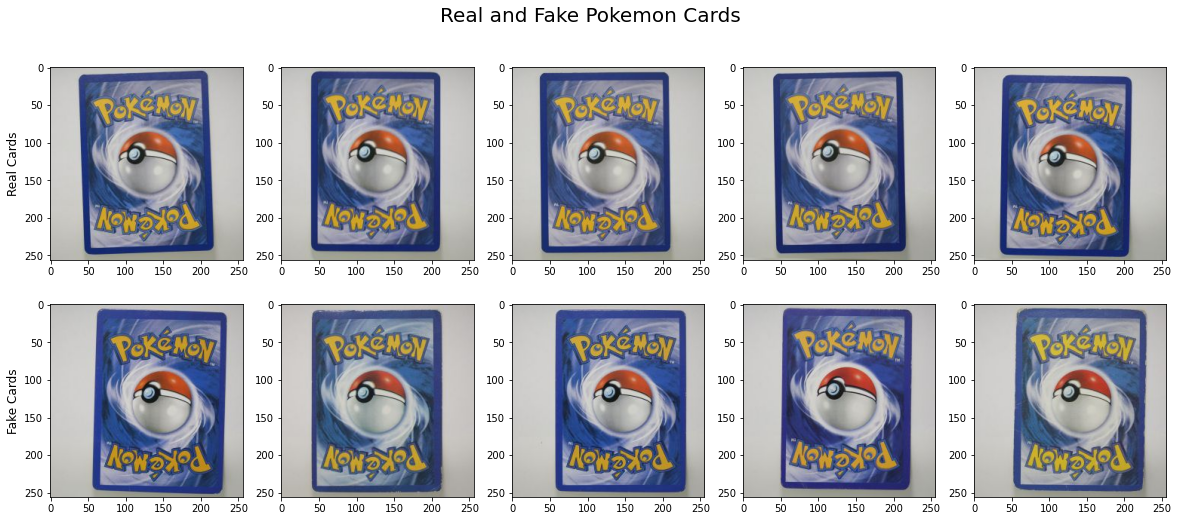

In [4]:
# random sampling
shuffled_data = shuffle(df_data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Real and Fake Pokemon Cards',fontsize=20)
# Real
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(base_tile_dir, idx)
    ax[0,i].imshow(readImage(path + '.JPG'))
ax[0,0].set_ylabel('Real Cards', size='large')
# Fake
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(base_tile_dir, idx)
    ax[1,i].imshow(readImage(path + '.JPG'))
ax[1,0].set_ylabel('Fake Cards', size='large')


# Split X and y in train/test and build folders


In [5]:
# Set the id as the index in df_data
df_data.set_index('id', inplace=True)
df_data.head()

,label,path
id,,
1,0,../input/real-and-fake-pokemon-cards/train/1.JPG
10,0,../input/real-and-fake-pokemon-cards/train/10.JPG
100,0,../input/real-and-fake-pokemon-cards/train/100...
101,0,../input/real-and-fake-pokemon-cards/train/101...
102,0,../input/real-and-fake-pokemon-cards/train/102...


In [6]:
# train_test_split # stratify=y creates a balanced validation set.
y = df_data['label']
df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

In [7]:
# Create directories
train_path = 'base_dir/train'
valid_path = 'base_dir/valid'
test_path = '../input/real-and-fake-pokemon-cards/test'
for fold in [train_path, valid_path]:
    for subf in ["0", "1"]:
        os.makedirs(os.path.join(fold, subf))

In [8]:
for image in df_train.index.values:
    # the id in the csv file does not have the .JPG extension therefore we add it here
    fname = image + '.JPG'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('../input/real-and-fake-pokemon-cards/train', fname)
    dst = os.path.join(train_path, label, fname)
    shutil.copyfile(src, dst)

for image in df_val.index.values:
    fname = image + '.JPG'
    label = str(df_data.loc[image,'label']) # get the label for a certain image
    src = os.path.join('../input/real-and-fake-pokemon-cards/train', fname)
    dst = os.path.join(valid_path, label, fname)
    shutil.copyfile(src, dst)

In [9]:
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 256
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

datagen = ImageDataGenerator(preprocessing_function=lambda x:(x - x.mean()) / x.std() if x.std() > 0 else x,
                            horizontal_flip=True,
                            vertical_flip=True)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='binary')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='binary')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='binary',
                                        shuffle=False)

Found 335 images belonging to 2 classes.
Found 38 images belonging to 2 classes.
Found 38 images belonging to 2 classes.


# Define the model 
**Model structure (optimizer: Adam):**

* In 
* [Conv2D*3 -> MaxPool2D -> Dropout] x3 --> (filters = 16, 32, 64)
* Flatten 
* Dense (256) 
* Dropout 
* Out

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.5

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(1, activation = "sigmoid"))

# Compile the model
model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])

2022-02-26 16:35:22.011871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 16:35:22.091385: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 16:35:22.092183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-26 16:35:22.093376: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

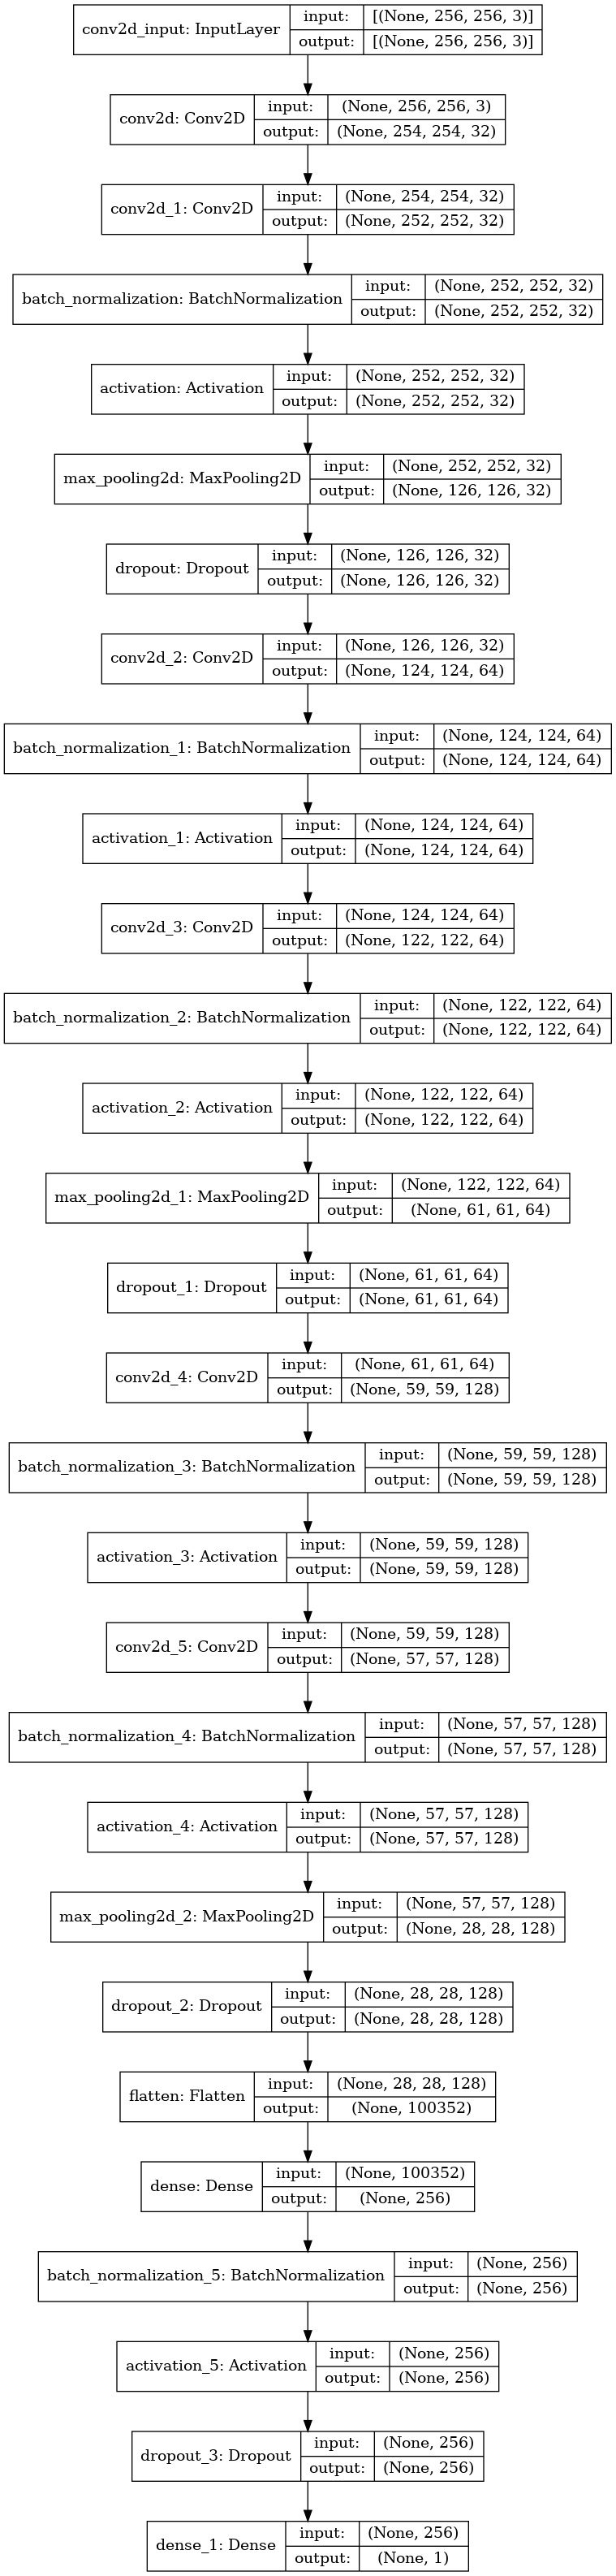

In [11]:
import tensorflow as tf
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

# Train

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=50,
                   callbacks=[reducel, earlystopper])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-02-26 16:35:26.194862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-02-26 16:35:28.035891: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


11/11 [==============================] - 11s 331ms/step - loss: 0.9026 - accuracy: 0.7612 - val_loss: 1839.1704 - val_accuracy: 0.3421
Epoch 2/50
11/11 [==============================] - 2s 176ms/step - loss: 0.2397 - accuracy: 0.9015 - val_loss: 1080.3931 - val_accuracy: 0.3421
Epoch 3/50
11/11 [==============================] - 2s 164ms/step - loss: 0.1426 - accuracy: 0.9433 - val_loss: 1301.3857 - val_accuracy: 0.3421

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
Epoch 4/50
11/11 [==============================] - 2s 169ms/step - loss: 0.0969 - accuracy: 0.9612 - val_loss: 523.7620 - val_accuracy: 0.3421
Epoch 5/50
11/11 [==============================] - 2s 168ms/step - loss: 0.0672 - accuracy: 0.9821 - val_loss: 273.5564 - val_accuracy: 0.3421
Epoch 6/50
11/11 [==============================] - 2s 187ms/step - loss: 0.0746 - accuracy: 0.9821 - val_loss: 156.3781 - val_accuracy: 0.3421
Epoch 7/50
11/11 [==============================] - 2s 172ms/s

In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction
y_pred_keras = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_gen.classes, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
auc_keras

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


38/38 [==============================] - 0s 5ms/step


1.0

# Plot ROC Curve

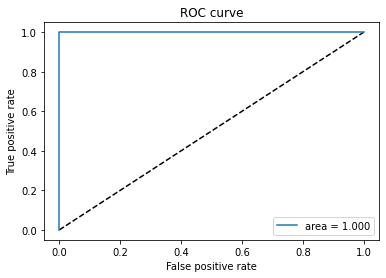

In [14]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Load test data and predict


In [15]:
base_test_dir = '../input/real-and-fake-pokemon-cards/test'
test_files = glob(os.path.join(base_test_dir,'*.JPG'))
submission = pd.DataFrame()
file_batch = 78
max_idx = len(test_files)
for idx in range(0, max_idx, file_batch):
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[4].split(".")[0])
    test_df['image'] = test_df['path'].map(imread)
    K_test = np.stack(test_df["image"].values)
    K_test = (K_test - K_test.mean()) / K_test.std()
    predictions = model.predict(K_test)
    predictions = list(map(lambda x: 0 if x<0.5 else 1, predictions)) # get binary values predictions with 0.5 as thresold
    test_df['predict'] = predictions
    submission = pd.concat([submission, test_df[["id", "predict"]]])
submission.head()
df_test = pd.read_csv('../input/real-and-fake-pokemon-cards/test_labels.csv')
df_test['id'] = df_test['id'].astype('str')
check_results = pd.merge(submission, df_test, on='id')

Indexes: 0 - 78


In [16]:
check_results

,id,predict,label
0,436,1,1
1,429,1,1
2,377,0,0
3,446,1,1
4,425,1,1
...,...,...,...
73,433,1,1
74,395,0,0
75,423,1,1
76,422,1,1


In [17]:
from sklearn.metrics import accuracy_score
model_accuracy = accuracy_score(check_results['label'],check_results['predict'])
print('Accuracy =', model_accuracy)

Accuracy = 0.9871794871794872


In [18]:
check_results.to_csv("results.csv", index = False, header = True)